# Basic Statistics

## Set Up

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from IPython.display import Markdown, HTML, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

from reload_recursive import reload_recursive
import sys
import os
from my_python_utils import smart_title

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace
from collections import defaultdict
import pingouin as pg


In [4]:
t1_data = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/paper1/data0/t1_data_full.csv", index_col='subid')
flair_data = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/paper1/data0/flair_data_full.csv", index_col="subid")
t1_flair_data = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/paper1/data0/t1_flair_data_full.csv", index_col="subid")

(array([  6.,  23.,  57., 125., 116.,  82.,  34.,  16.,   8.,   2.]),
 array([ 458.715424 ,  813.0231541, 1167.3308842, 1521.6386143,
        1875.9463444, 2230.2540745, 2584.5618046, 2938.8695347,
        3293.1772648, 3647.4849949, 4001.792725 ]),
 <BarContainer object of 10 artists>)

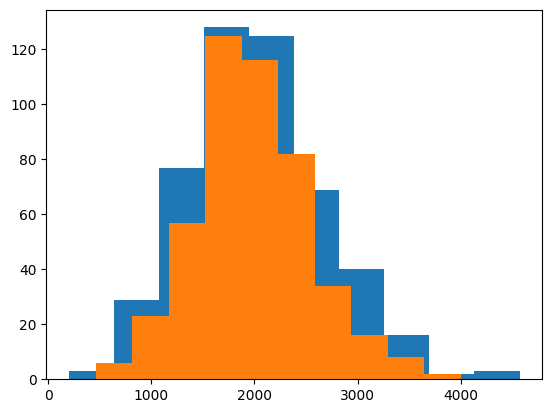

In [8]:
plt.hist(t1_data.choroid_volume)
plt.hist(flair_data.choroid_volume)

#### Reload modules

demographics, PMS/RMS, disability, maybe some volumes

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

from utils import zscore
from my_namespace import presentation_cols, colors

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/0-Basic_statistics"
)
if not fig_path.exists():
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

p = "<p style='font-family: Mononoki Nerd Font Mono;line-height: 1.3;font-size: 14px;'>"

## Analysis

In [8]:
data[NIND_patients]['DMT_hx_all']

subid
1027    0.0
1029    0.0
1064    0.0
1101    1.0
1105    0.0
1203    0.0
1224    0.0
1280    0.0
1283    0.0
1285    1.0
1317    0.0
1321    0.0
1344    1.0
1355    0.0
1383    0.0
1406    0.0
1423    0.0
1437    0.0
1463    1.0
1476    0.0
1486    0.0
1489    0.0
1492    0.0
1547    0.0
1548    0.0
1557    0.0
2005    0.0
2020    0.0
2057    0.0
2059    0.0
2070    0.0
2083    0.0
2085    0.0
2090    0.0
2097    0.0
2108    0.0
2110    0.0
2114    0.0
2123    0.0
2126    0.0
2129    0.0
2134    0.0
2142    0.0
2144    0.0
2146    0.0
2200    0.0
2206    0.0
2231    0.0
2243    0.0
Name: DMT_hx_all, dtype: float64

In [10]:
data.loc[NIND_patients, "subtype"]

subid
1027                                          Spinal DAVF
1029                                                  SVD
1064                                                  SVD
1101                                                  SVD
1105                             SVD and cord compression
1203                      Essential Tremor (+FamHx of MS)
1224                                         Migraine SVD
1280                                            CNS lupus
1283                          Lichen planus, fibromyalgia
1285                                  GBE1 Leukodystrophy
1317                                            CN6 palsy
1321                                             Chiari I
1344                    SVD (HLD, optic migraine) vs RRMS
1355                 SVD (tobacco, HLD, HTN) matching OCB
1383                  TBI, hyperhomocysteinemia (vs PPMS)
1406               cognitive impairment, gait instability
1423               SVD (afib, migraine) vs RRMS dx, 0 OCB
1437    

In [9]:
data.columns

Index(['subject', 'sz_onset', 'dzdur', 'MSSS', 'gMSSS', 'ARMSS', 'sex', 'age',
       'obs_start_date', 'obs_end_date',
       ...
       'periCSF_ratio_norm_log', 'periCSF_ratio2_norm_log',
       'periCSF_ratio2_norm2_log', 'PRL_LEVEL', 'PRL_LEVEL_CAT', 'WBV', 'WMV',
       'GMV', 'WTV', 'TIV'],
      dtype='object', length=208)

### Demographic and Clinical Data

In [9]:
model_data = data[MS_patients]

vars = ["age", "dzdur", "SDMT"]
max_width = max(len(outcome) for outcome in vars)
display_text = ""
display_text += f"{p}<u>MRI Volumes:</u></p>"
display_volumes = [
    f"{var:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var in vars
]

print("\n".join(display_volumes))

vars = ["EDSS"]
max_width = max(len(outcome) for outcome in vars)
display_text = ""
display_text += f"{p}<u>MRI Volumes:</u></p>"
display_volumes = [
    f"{var:<{max_width + 1}}: {model_data[var].median():0.2f} ({model_data[var].quantile(0.25):0.2f}, {model_data[var].quantile(0.75):0.2f})"
    for var in vars
]

print("\n".join(display_volumes))

print(f"Sex (F/M) : {sum(model_data['sex']=="Female")}/{sum(model_data['sex']=="Male")}")

print(f"RMS : {sum(RMS_patients)} ({sum(RMS_patients)/sum(MS_patients)*100:.0f}%)")
print(f"PMS : {sum(PMS_patients)} ({sum(PMS_patients)/sum(MS_patients)*100:.0f}%)")

age   : 47.75 ± 12.47
dzdur : 12.22 ± 10.17
SDMT  : 52.17 ± 13.77
EDSS : 2.00 (1.50, 3.50)
Sex (F/M) : 367/101
RMS : 371 (79%)
PMS : 97 (21%)


In [16]:
n_he = data.loc[MS_patients, 'DMT_hx_HE'].sum()
n_me = data.loc[MS_patients, 'DMT_hx_ME'].sum()
n_le = data.loc[MS_patients, 'DMT_hx_LE'].sum()
dmt_he_prcnt = data.loc[MS_patients, 'DMT_hx_HE'].sum() / sum(MS_patients)*100
dmt_me_prcnt = data.loc[MS_patients, 'DMT_hx_ME'].sum() / sum(MS_patients)*100
dmt_le_prcnt = data.loc[MS_patients, 'DMT_hx_LE'].sum() / sum(MS_patients)*100

print(f"High efficacy DMT: {n_he} ({dmt_he_prcnt:0.0f}%)")
print(f"Medium efficacy DMT: {n_me} ({dmt_me_prcnt:0.0f}%)")
print(f"Low efficacy DMT: {n_le} ({dmt_le_prcnt:0.0f}%)")

High efficacy DMT: 137.0 (29%)
Medium efficacy DMT: 45.0 (10%)
Low efficacy DMT: 124.0 (26%)


### MRI Measures

In [4]:
model_data = data[MS_patients]

vars = ["WBV", "WMV", "GMV", "WTV"]
max_width = max(len(outcome) for outcome in vars)
display_text = ""
display_text += f"{p}<u>MRI Volumes:</u></p>"
display_volumes = [
    f"{var:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var in vars
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
display(HTML(display_text))

In [5]:
mri_volumes = {
    "brain": "WBV (mm3)",
    "white": "WMV (mm3)",
    "grey": "GMV (mm3)",
    "THALAMUS_1": "WTV (mm3)",
    "cortical_thickness": "cortical_thickness (mm)",
}
inflammation_measures = {
    "CP": "choroid plexus (mm3)",
    "t2lv": "T2LV (mm3)",
    "PRL": "PRL count",
}
csf_compartments = {
    "LV": "LV (mm3)",
    "interCSF": "interthalamic CSF (mm3)",
    "thirdV": "third ventricle (mm3)",
    "fourthV": "fourth ventricle (mm3)",
    "periCSF": "subarachnoid CSF (mm3)",
}

# csf_compartments | mri_volumes | inflammation_measures

In [6]:
mri_volumes = {
    "brain": "whole brain volume",
    "white": "white matter volume",
    "grey": "grey matter volume",
    "THALAMUS_1": "whole thalamus volume",
    "cortical_thickness": "cortical_thickness (mm)",
}
inflammation_measures = {
    "CP": "choroid plexus (mm3)",
    "T2LV": "T2LV (mm3)",
    "PRL": "PRL count",
}
csf_compartments = {
    "LV": "lateral ventricles",
    "interCSF": "interthalamic CSF",
    "thirdV": "third ventricle",
    "fourthV": "fourth ventricle",
    "periCSF": "subarachnoid CSF",
    "CCR2": "CCR"
}
max_width = max(
    len(var_disp)
    for var_disp in (csf_compartments | mri_volumes | inflammation_measures).values()
)

# * MRI Volumes
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in mri_volumes.items()
]
print("MRI Volumes (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))

# * Measures of Inflammation
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in inflammation_measures.items()
]
print("\nMeasures of Inflammation:\n-----------------------------------------------")
print("\n".join(display_volumes))

# * CSF Compartments
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in csf_compartments.items()
]
print("\nCSF Compartments (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))

MRI Volumes (mm3):
-----------------------------------------------
whole brain volume      : 1041323.51 ± 102997.33
white matter volume     : 484966.16 ± 54254.00
grey matter volume      : 556357.35 ± 53965.54
whole thalamus volume   : 8962.35 ± 1627.81
cortical_thickness (mm) : 2.28 ± 0.13

Measures of Inflammation:
-----------------------------------------------
choroid plexus (mm3)    : 1719.71 ± 507.84
T2LV (mm3)              : 7810.70 ± 10733.67
PRL count               : 0.89 ± 1.79

CSF Compartments (mm3):
-----------------------------------------------
lateral ventricles      : 19492.70 ± 14859.00
interthalamic CSF       : 964.45 ± 348.45
third ventricle         : 955.76 ± 483.74
fourth ventricle        : 1749.45 ± 512.52
subarachnoid CSF        : 345018.14 ± 34930.85
CCR                     : 0.06 ± 0.04


In [7]:
lesion_volumes = {
    "T2LV": "total T2LV",
    "juxcort_T2LV": "juxtacortical T2LV",
    "periV_T2LV": "periventricular T2LV",
    "subcort_T2LV": "subcortical T2LV",
    "infraT_T2LV": "infratentorial T2LV"
}

max_width = max(
    len(var_disp)
    for var_disp in (lesion_volumes).values()
)

display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in lesion_volumes.items()
]
print("Lesion Volumes (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))


Lesion Volumes (mm3):
-----------------------------------------------
total T2LV           : 7810.70 ± 10733.67
juxtacortical T2LV   : 1549.93 ± 2447.36
periventricular T2LV : 5668.40 ± 9553.27
subcortical T2LV     : 484.41 ± 1240.98
infratentorial T2LV  : 114.95 ± 266.35


In [8]:
row_keys = [key for key in mri_volumes.keys()]
row_keys.extend([key for key in inflammation_measures.keys()])

volumes = ["WBV", "GMV", "WMV", "WTV", "cortical_thickness", "T2LV", "CP"]
df_dict = defaultdict(list)
for disease_group, group_name in zip([MS_patients, OIND_patients, NIND_patients], ["MS", "OIND", "NIND"]):
    model_data = data[disease_group]
    demo_dict[group_name].append(f"{model_data["age"].mean():0.1f} ± {model_data["age"].std():0.1f}")
    demo_dict[group_name].append(f"{sum(model_data['sex']=="Female")}/{sum(model_data['sex']=="Male")}")
    demo_dict[group_name].append(f"{model_data["dzdur"].mean():0.1f} ± {model_data["dzdur"].std():0.1f}")
    demo_dict[group_name].append(f"{model_data["EDSS"].median():0.2f} ({model_data["EDSS"].quantile(0.25):0.2f}, {model_data["EDSS"].quantile(0.75):0.2f})")
    
demo_df = pd.DataFrame(demo_dict, index=["age", "sex", "dzdur", "EDSS"])
demo_df.to_excel(fig_path / "disease_group_demographics.xlsx")

,MS,OIND,NIND
WBV,1097.16 ± 119.01,1110.09 ± 110.95,1144.80 ± 128.29
GMV,484.66 ± 61.96,498.53 ± 56.94,512.83 ± 68.13
WMV,612.50 ± 64.42,611.56 ± 58.20,631.97 ± 69.36
WTV,8.96 ± 1.63,9.68 ± 1.33,10.03 ± 1.22
cortical_thickness,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
T2LV,7.81 ± 10.73,3.63 ± 11.32,3.54 ± 5.53
CP,1.72 ± 0.51,1.70 ± 0.50,1.64 ± 0.50


In [9]:
check_data = data[data['dz_type3'].isin(["MS", "NIND", "NIND"])]
comp_dict = defaultdict(list)
check_data = data[data.dz_type3.isin(["MS", "NIND", "OIND"])]
for volume in volumes:
    model = smf.ols(f'{volume} ~ dz_type3 + age + Female + tiv', data=check_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Get p-value
    p_value = anova_table.loc['dz_type3', 'PR(>F)']

    # Calculate partial eta-squared
    ss_effect = anova_table.loc['dz_type3', 'sum_sq']
    ss_residual = anova_table.loc['Residual', 'sum_sq']
    partial_eta2 = ss_effect / (ss_effect + ss_residual)

    comp_dict["p Value"].append(f"{p_value:.3f}")
    comp_dict["η2"].append(f"{partial_eta2:.3f}")

comp_df = pd.DataFrame(comp_dict, index=volumes)
comp_df.to_excel(fig_path / "disease_group_volume_comparisons.xlsx")


,p Value,η2
WBV,2.899828e-02,0.012746
GMV,9.895219e-03,0.016585
WMV,3.431272e-01,0.003868
WTV,9.251671e-07,0.049092
cortical_thickness,5.219540e-02,0.010641
T2LV,3.823690e-04,0.028413
CP,2.777664e-01,0.004630


In [34]:
sum(MS_patients)

468

In [10]:
lesion_volumes = {
    "T2LV": "total T2LV",
    "juxcort_T2LV": "juxtacortical T2LV",
    "periV_T2LV": "periventricular T2LV",
    "subcort_T2LV": "subcortical T2LV",
    "infraT_T2LV": "infratentorial T2LV"
}

max_width = max(
    len(var_disp)
    for var_disp in (lesion_volumes).values()
)

for name, patients in zip(["MS", "OIND", 'NIND'], [MS_patients, OIND_patients, NIND_patients]):
    display(Markdown(f"### {name}"))
    display_volumes = [
        f"{var_disp:<{max_width + 1}}: {data.loc[patients, var].mean():0.2f} ± {data.loc[patients, var].std():0.2f}"
        for var, var_disp in lesion_volumes.items()
    ]
    print("Lesion Volumes (mm3):\n-----------------------------------------------")
    print("\n".join(display_volumes))


### MS

Lesion Volumes (mm3):
-----------------------------------------------
total T2LV           : 7810.70 ± 10733.67
juxtacortical T2LV   : 1549.93 ± 2447.36
periventricular T2LV : 5668.40 ± 9553.27
subcortical T2LV     : 484.41 ± 1240.98
infratentorial T2LV  : 114.95 ± 266.35


### OIND

Lesion Volumes (mm3):
-----------------------------------------------
total T2LV           : 3630.22 ± 11321.97
juxtacortical T2LV   : 600.64 ± 1112.58
periventricular T2LV : 2692.76 ± 10979.07
subcortical T2LV     : 269.30 ± 428.57
infratentorial T2LV  : 67.52 ± 151.14


### NIND

Lesion Volumes (mm3):
-----------------------------------------------
total T2LV           : 3543.16 ± 5528.27
juxtacortical T2LV   : 930.34 ± 1850.30
periventricular T2LV : 2181.69 ± 3735.42
subcortical T2LV     : 396.18 ± 569.66
infratentorial T2LV  : 34.94 ± 70.17


In [8]:
test_data = data[MS_patients]

for var in ["brain", "white", "grey", "tiv"]:
    test_data[var] = test_data[var] / 1000

for var in ["brain", "white", "grey"]:
    test_data[f"{var}_fix"] = test_data[var] / test_data["vscaling"]


cols = ["brain", "cat12_brain", "white", "cat12_white", "grey", "cat12_grey"]
max_width = max(len(outcome) for outcome in cols)


vars = ("brain", "cat12_brain", "WBV")
for vars in [
    ("brain", "cat12_brain", "WBV"),
    ("white", "cat12_wm", "WMV"),
    ("grey", "cat12_gm", "GMV"),
    ("brain_fix", "cat12_brain", "WBV"),
    ("white_fix", "cat12_wm", "WMV"),
    ("grey_fix", "cat12_gm", "GMV"),
    ("tiv", "cat12_tiv", "TIV"),
]:
    print(f"{vars[2]}\n-----------")
    print(
        f"{vars[0]:<{max_width + 1}}: {test_data[vars[0]].mean():0.2f} ± {test_data[vars[0]].std():0.2f}"
    )
    print(
        f"{vars[1]:<{max_width + 1}}: {test_data[vars[1]].mean():0.2f} ± {test_data[vars[1]].std():0.2f}"
    )

    tmp_data = test_data[list(vars[:2])].dropna()
    slope, intercept, r, p, se = stats.linregress(tmp_data[vars[0]], tmp_data[vars[1]])
    pearsonr = stats.pearsonr(tmp_data[vars[0]], tmp_data[vars[1]])
    print(
        f"{'compare':<{max_width + 1}}: ρ={pearsonr.statistic:0.2f}, p={pearsonr.pvalue:0.2}, R2={r**2:0.2f}"
    )
    print("\n")

WBV
-----------
brain       : 1406.87 ± 81.82
cat12_brain : 1097.16 ± 119.01
compare     : ρ=0.41, p=1.3e-20, R2=0.17


WMV
-----------
white       : 654.42 ± 38.82
cat12_wm    : 612.50 ± 64.42
compare     : ρ=0.35, p=7.1e-15, R2=0.12


GMV
-----------
grey        : 752.45 ± 54.41
cat12_gm    : 484.66 ± 61.96
compare     : ρ=0.14, p=0.0022, R2=0.02


WBV
-----------
brain_fix   : 1041.32 ± 103.00
cat12_brain : 1097.16 ± 119.01
compare     : ρ=0.96, p=3.6e-253, R2=0.92


WMV
-----------
white_fix   : 484.97 ± 54.25
cat12_wm    : 612.50 ± 64.42
compare     : ρ=0.74, p=2.1e-83, R2=0.55


GMV
-----------
grey_fix    : 556.36 ± 53.97
cat12_gm    : 484.66 ± 61.96
compare     : ρ=0.84, p=2.9e-123, R2=0.70


TIV
-----------
tiv         : 1493.67 ± 128.33
cat12_tiv   : 1410.22 ± 137.61
compare     : ρ=0.95, p=1.9e-238, R2=0.90




In [ ]:
test_data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/Clinical_Data_All_updated.csv"
)

slope, intercept, r, p, se = stats.linregress(
    test_data["brain"], test_data["cat12_brain"]
)
pearsonr = stats.pearsonr(test_data["brain"], test_data["cat12_brain"])
print(f"WBV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data["white"], test_data["cat12_wm"])
pearsonr = stats.pearsonr(test_data["white"], test_data["cat12_wm"])
print(f"WMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data["grey"], test_data["cat12_gm"])
pearsonr = stats.pearsonr(test_data["grey"], test_data["cat12_gm"])
print(f"GMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

WBV: ρ=0.40, R2=0.16, p=2.9e-23
WMV: ρ=0.36, R2=0.13, p=1.4e-18
GMV: ρ=0.11, R2=0.01, p=0.0084


## Assumption Checks

### Functions

In [4]:
raw_ms_data = data[MS_patients]

def zscore2(df, skip_vars=None):
    """Z-score numeric columns, preserving correlation structure.
    
    WARNING: This drops rows with ANY missing values in numeric columns
    to maintain proper covariance structure.
    """
    if skip_vars is None:
        skip_vars = []
    
    df_z = df.copy()
    numeric_cols = df_z.select_dtypes(include="number").columns
    numeric_cols = numeric_cols[~numeric_cols.isin(skip_vars)]
    
    # Drop rows with any NaN in numeric columns FIRST
    df_z = df_z.dropna(subset=numeric_cols)
    
    # Now z-score (no NaNs remain, so no need for nan_policy)
    df_z[numeric_cols] = (df_z[numeric_cols] - df_z[numeric_cols].mean()) / df_z[numeric_cols].std()
    
    return df_z


def check_vif(raw_data, vars):
    raw_data = raw_data[vars]
    data = zscore2(raw_data)
    X = data[vars]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.set_index("Variable")


def quick_print_vif(raw_data, variables, print_vars=None):
    if print_vars is None:
        print_vars = variables
    vif = check_vif(raw_data, variables)
    print_vif = vif.loc[print_vars, "VIF"]
    print(", ".join(variables))
    print("-"*40)
    display(Markdown(print_vif.to_markdown()))
    print("\n")

### VIF

In [6]:
variables = ["CP", "T2LV_log1p", "PRL", "tiv", "WBV", "age", "Female"]
quick_print_vif(raw_ms_data, variables)

variables = ["CP", "T2LV_log1p", "tiv", "WTV", "CT", "age", "Female"]
quick_print_vif(raw_ms_data, variables)

CP, T2LV_log1p, PRL, tiv, WBV, age, Female
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| CP         | 1.8093  |
| T2LV_log1p | 1.56558 |
| PRL        | 1.25511 |
| tiv        | 8.90633 |
| WBV        | 9.61578 |
| age        | 1.70912 |
| Female     | 1.0764  |



CP, T2LV_log1p, tiv, WTV, CT, age, Female
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| CP         | 1.56571 |
| T2LV_log1p | 1.93046 |
| tiv        | 1.67956 |
| WTV        | 3.30999 |
| CT         | 2.2393  |
| age        | 1.36064 |
| Female     | 1.08016 |

#### VIF for models with WTV and additional thalamic nuclei

In [6]:
for nucleus in ["medial", "posterior", "ventral", "anterior"]:
    variables = ["CP", "WTV", nucleus, "age", "Female", "tiv",]
    quick_print_vif(raw_ms_data, variables, print_vars=["WTV", nucleus, "CP"])

CP, WTV, medial, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 9.64538 |
| medial     | 9.22195 |
| CP         | 1.60764 |



CP, WTV, posterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WTV        | 11.396   |
| posterior  | 10.2198  |
| CP         |  1.56631 |



CP, WTV, ventral, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 8.16626 |
| ventral    | 7.89023 |
| CP         | 1.67143 |



CP, WTV, anterior, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 2.9413  |
| anterior   | 2.30892 |
| CP         | 1.55536 |

In [9]:
for nucleus in ["medial", "posterior", "ventral", "anterior"]:
    variables = ["CP", "WBV", nucleus, "age", "Female", "tiv",]
    quick_print_vif(raw_ms_data, variables, print_vars=["WBV", nucleus, "CP"])

CP, WBV, medial, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.9061  |
| medial     |  2.60879 |
| CP         |  1.83232 |



CP, WBV, posterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.3559  |
| posterior  |  2.34263 |
| CP         |  1.81788 |



CP, WBV, ventral, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.5056  |
| ventral    |  2.55451 |
| CP         |  1.79737 |



CP, WBV, anterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 10.0753  |
| anterior   |  1.6721  |
| CP         |  1.78628 |